In [1]:
# !pip install --upgrade -q  efficientnet_pytorch  \
#                            transformers \
#                            pytorch_lightning \
#                            sacrebleu \
#                            sentencepiece \ 
#                            neptune-client


In [2]:
import os
import torch
import json

from matplotlib import pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.cpu_count(), torch.cuda.get_device_name() if device == "cuda" else None

(8, 'Tesla T4')

In [18]:
HPARAMS = {
    "name": "ocr-base-squad",
    "learning_rate": 5e-5,
    "batch_size": 4,
    "batch_accum": 2,
    "val_check_interval": 0.25,
    "limit_val_batches": 0.02,
    "patience": 30,
}

In [4]:
! wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
! wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula7/arial.ttf .

File 'train-v2.0.json' already there; not retrieving.

File 'dev-v2.0.json' already there; not retrieving.

Skipping existing item: file://./arial.ttf


In [5]:
from transformers import T5ForConditionalGeneration, T5Tokenizer


tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [6]:
data = json.load(open("train-v2.0.json"))

In [7]:
import textwrap
import numpy as np

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

from matplotlib.pyplot import imshow


def text_to_image(text: str, max_width: int, max_height: int, ):

    font_size = np.random.randint(12, 13)
    font = ImageFont.truetype("arial.ttf", font_size)
    
    image = Image.new('RGB', (max_width, max_height), (255, 255, 255))  # white background.
    d = ImageDraw.Draw(image)
    
    left_border = np.random.randint(4, 6)
    top_border = np.random.randint(1, 2)
    
#     wraps = textwrap.wrap(text, width=(3400 - left_border) // font_size)
    
    d.text((left_border, top_border), text, font=font, fill=(0, 0, 0))
#     for col, wrap in enumerate(wraps): 
#         d.text((left_border, top_border + 1.2 * font_size * col), wrap, font=font, fill=(0, 0, 0))
    
    text_width, text_height = d.textsize(text)  # Caso queria saber o tamanho do texto.
    
    # random_rotation = np.random.uniform(-.1, .1)
    
    # image = image.rotate(random_rotation, expand=0, fillcolor=(255, 255, 255))

    arr = np.array(image).astype(np.int)
    arr += np.random.uniform(-30, 30, size=arr.shape).astype(np.int)
    
    return arr.clip(0, 255).astype(np.uint8)

In [8]:
data["data"][0]["paragraphs"][0]['qas']

[{'question': 'When did Beyonce start becoming popular?',
  'id': '56be85543aeaaa14008c9063',
  'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
  'is_impossible': False},
 {'question': 'What areas did Beyonce compete in when she was growing up?',
  'id': '56be85543aeaaa14008c9065',
  'answers': [{'text': 'singing and dancing', 'answer_start': 207}],
  'is_impossible': False},
 {'question': "When did Beyonce leave Destiny's Child and become a solo singer?",
  'id': '56be85543aeaaa14008c9066',
  'answers': [{'text': '2003', 'answer_start': 526}],
  'is_impossible': False},
 {'question': 'In what city and state did Beyonce  grow up? ',
  'id': '56bf6b0f3aeaaa14008c9601',
  'answers': [{'text': 'Houston, Texas', 'answer_start': 166}],
  'is_impossible': False},
 {'question': 'In which decade did Beyonce become famous?',
  'id': '56bf6b0f3aeaaa14008c9602',
  'answers': [{'text': 'late 1990s', 'answer_start': 276}],
  'is_impossible': False},
 {'question': 'In what R&B group

In [9]:
import random
import json
import h5py

import nltk
import regex
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


# Normalization suggested by the EfficientNet library when trained with adversarial examples.
# https://github.com/lukemelas/EfficientNet-PyTorch#update-january-23-2020
transform = transforms.Compose([
    transforms.Lambda(lambda img: img * 2.0  - 1.0),
])

nltk.download("punkt")


class OCRAugmentationDataset(Dataset):
    """
    Dataset that loads image instances lazily to memory.
    """

    def __init__(self, data, img_transform=lambda x: x):        
        
        self.img_transform = img_transform
        self.context = [
            sentence.encode("latin-1", "ignore").decode("latin-1")
            for topic in data["data"]
            for paragraph in topic["paragraphs"]
            for sentence in nltk.sent_tokenize(paragraph["context"])
        ]
    

    def __len__(self):
        # 10 % of the samples are blank.
        # return int(1.1 * len(self.context))
        return len(self.context)
    
    def __getitem__(self, idx):
    
        n_sentences = random.randint(1, 3)
        cap = "".join(self.context[idx:idx + n_sentences])
        
        words = nltk.word_tokenize(cap)
        
        idx = sorted(set(
            random.randint(0, len(words) - 1)
            for i in range(int(0.15 * len(words)))
        ))
                
        targets = [words[i] for i in idx]
        
        for t, i in enumerate(idx):
            words[i] = f"<extra_id_{t}>"
        
        masked = " ".join(words)

        img = text_to_image(text=cap, max_width=3800, max_height=16)

        # Convert to float.
        img = np.moveaxis(img, 2, 0).astype(float)

        # Normalize image between 0 and 1.
        img = (img - img.min()) / np.max([img.max() - img.min(), 1])

        targets = " ".join(f"<extra_id_{t}> {w}" for t, w in enumerate(targets))
        
        if random.random() > .5:
            masked = "Read: "
            targets = cap
            
        else:
            masked = f"Model: {masked}"
        
        return self.img_transform(img), masked, targets
    

train_set = OCRAugmentationDataset(json.load(open("train-v2.0.json")), img_transform=transform)
val_set = OCRAugmentationDataset(json.load(open("dev-v2.0.json")), img_transform=transform)

[nltk_data] Downloading package punkt to /home/gsurita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


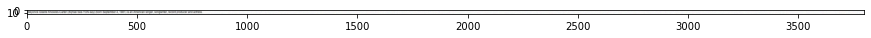

Read: 
Beyoncé Giselle Knowles-Carter (/bijnse/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.


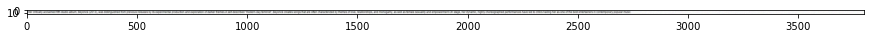

Model: <extra_id_0> critically acclaimed <extra_id_1> studio album , Beyoncé ( 2013 ) , was distinguished <extra_id_2> previous releases by its experimental production and <extra_id_3> of darker themes.A self-described `` modern-day feminist '' , Beyoncé creates <extra_id_4> that are often characterized by themes of <extra_id_5> , relationships , <extra_id_6> monogamy , as <extra_id_7> as female sexuality and empowerment.On stage , her <extra_id_8> , highly choreographed performances <extra_id_9> led to critics hailing her as one of the best entertainers <extra_id_10> contemporary popular music .
<extra_id_0> Her <extra_id_1> fifth <extra_id_2> from <extra_id_3> exploration <extra_id_4> songs <extra_id_5> love <extra_id_6> and <extra_id_7> well <extra_id_8> dynamic <extra_id_9> have <extra_id_10> in


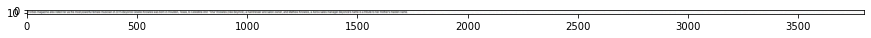

Read: 
Forbes magazine also listed her as the most powerful female musician of 2015.Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager.Beyoncé's name is a tribute to her mother's maiden name.


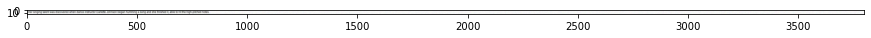

Model: Her singing talent was discovered when dance instructor Darlette Johnson began humming a song and she finished it , able <extra_id_0> hit the <extra_id_1> <extra_id_2> .
<extra_id_0> to <extra_id_1> high-pitched <extra_id_2> notes


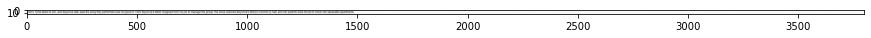

Model: Girl 's Tyme failed to win , and Beyoncé later <extra_id_0> the song <extra_id_1> performed was not good.In 1995 Beyoncé 's father resigned from his job to manage the <extra_id_2> move reduced Beyoncé 's family 's income by <extra_id_3> <extra_id_4> and her parents were forced to move <extra_id_5> <extra_id_6> apartments .
<extra_id_0> said <extra_id_1> they <extra_id_2> group.The <extra_id_3> half <extra_id_4> , <extra_id_5> into <extra_id_6> separated


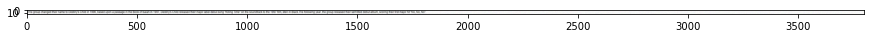

Read: 
The group changed their name to Destiny's Child in 1996, based upon a passage in the Book of Isaiah.In 1997, Destiny's Child released their major label debut song "Killing Time" on the soundtrack to the 1997 film, Men in Black.The following year, the group released their self-titled debut album, scoring their first major hit "No, No, No".


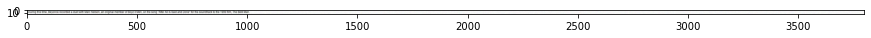

Read: 
During this time, Beyoncé recorded a duet with Marc Nelson, an original member of Boyz II Men, on the song "After All Is Said and Done" for the soundtrack to the 1999 film, The Best Man.


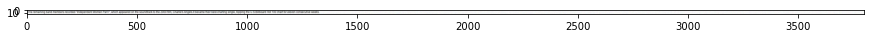

Model: <extra_id_0> remaining band members recorded `` Independent Women Part I '' , <extra_id_1> <extra_id_2> on the soundtrack to the 2000 <extra_id_3> , Charlie 's <extra_id_4> became their best-charting single , topping the U.S.Billboard Hot 100 chart <extra_id_5> eleven consecutive weeks .
<extra_id_0> The <extra_id_1> which <extra_id_2> appeared <extra_id_3> film <extra_id_4> Angels.It <extra_id_5> for


In [10]:
for (img, text, target), i in zip(train_set, range(64)):
    if i % 8 != 0:
        continue
    
    norm_img = (img + 1) / 2.

    plt.figure(figsize = (15,15))
    plt.imshow(np.moveaxis(norm_img, 0, 2))
    plt.show()
    
    print(text)
    print(target)

In [11]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AdamW
from transformers import T5ForConditionalGeneration, T5Tokenizer


import numpy as np
import sacrebleu
import pytorch_lightning as pl



class OCRModule(pl.LightningModule):

    def __init__(self):
        super().__init__()
    
        self.decoder = T5ForConditionalGeneration.from_pretrained('t5-base')
        
        # Patch convolution. Basically tranform the 2D image into 16x16 patches with 2048 dimensions.
        self.patch = nn.Conv2d(in_channels=3, out_channels=self.decoder.config.d_model, kernel_size=16, stride=16) # , padding=4)
        
        # Convert patches from 2048 to 512 dimensions.
        self.linear = nn.Linear(self.decoder.config.d_model, self.decoder.config.d_model)
        
        # Embedding to describe data type.
        self.dtype_embedding = nn.Embedding(2, self.decoder.config.d_model)
        
        self.txt_pos_embedding = nn.Embedding(2048, self.decoder.config.d_model)
        self.img_pos_embedding = nn.Embedding(2048, self.decoder.config.d_model)
        
    def _embeds_forward(self, img, question):
        
        # Compute patches to feed the transformer.
        features = self.patch(img)

        # Reshape the output to the 2D format of the tranformer.
        img_inputs = features \
            .permute(0, 2, 3, 1) \
            .reshape(features.shape[0], -1, self.decoder.config.d_model)

        img_pos_emb = self.img_pos_embedding(torch.arange(img_inputs.size(1), device=img.device)).unsqueeze(0)
        img_inputs = img_inputs + img_pos_emb + self.dtype_embedding._parameters["weight"][0]
        
        txt_pos_emb = self.txt_pos_embedding(torch.arange(question.size(1), device=img.device)).unsqueeze(0)
        txt_inputs = self.decoder.shared(question) + txt_pos_emb + self.dtype_embedding._parameters["weight"][1] 
        
        return torch.cat([txt_inputs, img_inputs], dim=1)

    def forward(self, imgs=None, questions=None, inputs_embeds=None, decoder_input_ids=None, labels=None):

        # Pass efficientnet hidden states as embeddings for the transformer encoder input.
        inputs_embeds = (
            self._embeds_forward(imgs, questions)
            if inputs_embeds is None else inputs_embeds
        )
        
        return self.decoder(
            inputs_embeds=inputs_embeds,
            decoder_input_ids=decoder_input_ids, 
            labels=labels,
        )

    def generate(self, img, question, max_len=128):

        # We need to implement our own generate loop as transformers doesn't accept 
        # precomputed embeddings on the generate method.
        # Issue: https://github.com/huggingface/transformers/issues/7626
        
        # Precompute embeddings to speedup generation as they don't change.
        inputs_embeds = self._embeds_forward(img, question)

        decoder_input_ids = torch.full(
            (1, 1), self.decoder.config.decoder_start_token_id, dtype=torch.long, device=img.device
        )

        for i in range(max_len):
            with torch.no_grad():
                output = self.forward(decoder_input_ids=decoder_input_ids, 
                                      inputs_embeds=inputs_embeds)
            
            logits = output[0]
            next_token_logits = logits[:, -1, :]
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1).to(img.device)

            if torch.eq(next_token_id[:, -1], self.decoder.config.eos_token_id).all():
                break

        return decoder_input_ids

    def training_step(self, batch, batch_idx):
        imgs, questions, targets, raw_targets = batch
        output = self(imgs, questions, labels=targets)
        loss = output[0]
        self.log("train_loss", loss.cpu().item())

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, questions, targets, raw_targets = batch
        tokens = [self.generate(im.view((1,) + im.shape), questions)[0].cpu() for im in imgs]
        
        return (tokens, targets)

    def validation_epoch_end(self, validation_step_outputs):
        validation_step_outputs = list(validation_step_outputs)
    
        tokens_batch = [t for out in validation_step_outputs for t in out[0]]
        reference_batch = [r for out in validation_step_outputs for r in out[1]]
        
        reference_batch = tokenizer.batch_decode(reference_batch, skip_special_tokens=True)
        generated_batch = tokenizer.batch_decode(tokens_batch, skip_special_tokens=True)
        
        bleu = sacrebleu.corpus_bleu(generated_batch, [reference_batch])
        
        em = np.average([compute_exact(g, r) for g, r in zip(generated_batch, reference_batch)])
        f1 = np.average([compute_f1(g, r) for g, r in zip(generated_batch, reference_batch)])
        
        self.log("val_bleu_score", bleu.score, prog_bar=True)
        self.log("val_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("val_exact_match", em, prog_bar=True)
        self.log("val_word_f1", f1, prog_bar=True)

        return {
            "val_bleu_score": bleu.score,
            "val_bleu_1": bleu.precisions[0],
            "val_bleu_4": bleu.precisions[3],
            "val_exact_match": em,
            "val_word_f1": f1,
        }

    def test_step(self, batch, batch_idx):
        imgs, questions, targets, raw_targets = batch
        tokens = [self.generate(im.view((1,) + im.shape), questions)[0].cpu() for im in imgs]
        
        return (tokens, targets)
    
    def test_epoch_end(self, validation_step_outputs):
        validation_step_outputs = list(validation_step_outputs)
    
        tokens_batch = [t for out in validation_step_outputs for t in out[0]]
        reference_batch = [r for out in validation_step_outputs for r in out[1]]
        
        reference_batch = tokenizer.batch_decode(reference_batch, skip_special_tokens=True)
        generated_batch = tokenizer.batch_decode(tokens_batch, skip_special_tokens=True)
        
        bleu = sacrebleu.corpus_bleu(generated_batch, [reference_batch])
        
        em = np.average([compute_exact(g, r) for g, r in zip(generated_batch, reference_batch)])
        f1 = np.average([compute_f1(g, r) for g, r in zip(generated_batch, reference_batch)])
        
        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("test_exact_match", em, prog_bar=True)
        self.log("test_word_f1", f1, prog_bar=True)
        
        return {
            "test_bleu_score": bleu.score,
            "test_bleu_1": bleu.precisions[0],
            "test_bleu_4": bleu.precisions[3],
            "test_exact_match": em,
            "test_word_f1": f1,
        }
        
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=HPARAMS["learning_rate"])

In [13]:
model = OCRModule()
model = model.load_from_checkpoint("./logs/ocr-base-squad-epoch=0-val_word_f1=0.23.ckpt")


In [14]:
import os
import pytorch_lightning as pl
from transformers import T5ForConditionalGeneration, T5Tokenizer


tokenizer = T5Tokenizer.from_pretrained('t5-base')



def collate_fn(batch):
    """
    Input any (selected randomly) caption sample for every image. Useful for training.
    """
    
    imgs = [r[0] for r in batch]
    texts = [r[1] for r in batch]
    targets = [r[2] for r in batch]
    
    batch_texts = tokenizer.batch_encode_plus(texts, return_tensors="pt", padding="longest")
    batch_targets = tokenizer.batch_encode_plus(targets, return_tensors="pt", padding="longest")

    return (
        torch.tensor(imgs, dtype=torch.float), 
        batch_texts["input_ids"], 
        batch_targets["input_ids"],
        targets,
    )


name = "ocr-base-long"

train_loader = DataLoader(
    train_set, 
    batch_size=HPARAMS["batch_size"], 
    shuffle=True, 
    num_workers=os.cpu_count(), 
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_set, 
    batch_size=1, num_workers=os.cpu_count(), collate_fn=collate_fn)

# Log results to CSV (so we can plot them later).
csv_logger = pl.loggers.csv_logs.CSVLogger(f"./logs", name=name)

# Log results to Neptune.
neptune_logger = pl.loggers.neptune.NeptuneLogger(
    api_key="",
    project_name=f"gabisurita/{name}",
    params=HPARAMS,
)

# Early stop if val BLEU score doesnt increase for 10 epochs.
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_word_f1', patience=HPARAMS["patience"], mode='max')

# Checkpoint the best model.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    prefix=name,
    filepath="logs/{epoch}-{val_word_f1:.2f}", 
    monitor="val_word_f1", 
    mode="max",
)


trainer = pl.Trainer(
    gpus=1,  
    logger=[csv_logger, neptune_logger],
    callbacks=[early_stop_callback],
    checkpoint_callback=checkpoint_callback, 
    
    accumulate_grad_batches=HPARAMS["batch_accum"],
    # Run validation over a smaller sample.
    val_check_interval=HPARAMS["val_check_interval"],
    limit_val_batches=HPARAMS["limit_val_batches"],
)

https://ui.neptune.ai/gabisurita/ocr-base-long/e/OC-52


NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [19]:
trainer.fit(model, train_loader, val_loader)


  | Name              | Type                       | Params
-----------------------------------------------------------------
0 | decoder           | T5ForConditionalGeneration | 222 M 
1 | patch             | Conv2d                     | 590 K 
2 | linear            | Linear                     | 590 K 
3 | dtype_embedding   | Embedding                  | 1.5 K 
4 | txt_pos_embedding | Embedding                  | 1.6 M 
5 | img_pos_embedding | Embedding                  | 1.6 M 


Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-52. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 5e750347-5272-4dfa-a154-7a08374c66e2.

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-52. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 5e750347-5272-4dfa-a154-7a08374c66e2.

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-52. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 5e750347-5272-4dfa-a154-7a08374c66e2.

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-52. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 5e750347-5272-4dfa-a154-7a08374c66e2.

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-52. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 5e750347-5272-4dfa-a154-7a08374c66e2.

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-52. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 5e750347-5272-4dfa-a154-7a08374c66e2.

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-52. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 5e750347-5272-4dfa-a154-7a08374c66e2.

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-52. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 5e750347-5272-4dfa-a154-7a08374c66e2.

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-52. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 5e750347-5272-4dfa-a154-7a08374c66e2.

RuntimeError: CUDA out of memory. Tried to allocate 324.00 MiB (GPU 0; 14.73 GiB total capacity; 13.27 GiB already allocated; 133.88 MiB free; 13.89 GiB reserved in total by PyTorch)

In [16]:
_ = model.cpu()

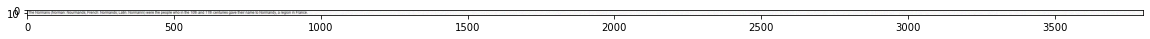

Model: The Normans ( Norman : Nourmands ; French : Normands ; Latin : Normanni ) were<extra_id_0> people who in the 10th and 11th centuries gave<extra_id_1><extra_id_2> to Normandy, a region<extra_id_3><extra_id_4>.

the their name in France

the their name in France



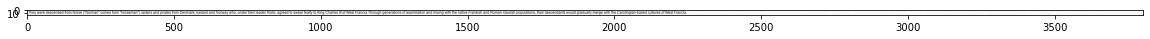

Model: They were<extra_id_0> from Norse (  ⁇ <extra_id_1> '' comes from<extra_id_2><extra_id_3> '' ) raiders and pirates<extra_id_4> Denmark, Iceland and Norway who,<extra_id_5> their<extra_id_6> Rollo,<extra_id_7> to swear fealty to King Charles<extra_id_8> of West Francia.Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their<extra_id_9> would gradually merge with the Carolingian-based cultures of West Francia.

descended Norman  Norseman from under leader agreed III descendants

descended Norman  Norman from under leader agreed II descendants



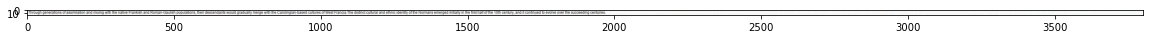

Model:<extra_id_0> generations of assimilation and mixing with the native<extra_id_1> and Roman-Gaulish populations, their descendants<extra_id_2> gradually merge with the Carolingian-based cultures of West Francia.The distinct cultural and<extra_id_3> identity<extra_id_4> the Normans emerged initially in the<extra_id_5> half of the 10th century, and<extra_id_6> continued to evolve over the succeeding centuries.

Through Frankish would ethnic of first it

Through French would ethnic of first it



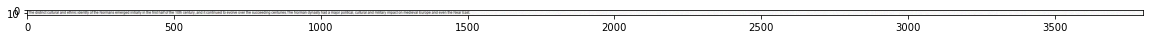

Read:

The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.The Norman dynasty had a major political, cultural and military impact on medieval Europe and even the Near East.

The distinct cultural and ethnic identity of the Nanmas remained virtually in the first half of the 19th century, and it continued to evolve over the succeeding centuries.The Nanmar dynast had a major political, cultural and military impact on mainland Europe and even the Near East.



In [17]:
from matplotlib import pyplot as plt
import cv2


# custom_examples = [
#     "Pancakes are good.",
#     "To be or not to be?",
#     "Coca-cola",
#     "Maybe this model is so good at grammar that it doesnt learn high level image representations",
#     "123 is smaller than 321",
#     "Português é uma língua muito difícil",
#     "Language models suffer from vocabulary mismatch problems.",
# ]

# custom_examples = {
#     "data": [
#         {
#             "paragraphs": [
#                 {
#                     "context": e
#                 }
#                 for e in custom_examples
#             ]
#         }
#     ]
# }

# custom_set = OCRAugmentationDataset(custom_examples, img_transform=transform)
# custom_loader = DataLoader(custom_set, batch_size=1, collate_fn=collate_fn)


for batch, i in zip(val_loader, range(4)):
        
    attention_weights = []
    imgs, texts, targets, refs = batch

    for (img, text, ref) in zip(imgs, texts, refs):
        norm_img = (img.numpy() + 1) / 2.
        
        plt.figure(figsize = (20,20))
        plt.imshow(np.moveaxis(norm_img, 0, 2))
        plt.show()
        tokens = model.generate(img.view((1,) + img.shape), text.view((1,) + text.shape))
        
        print(tokenizer.batch_decode(texts)[0])
        print()
        print(tokenizer.batch_decode(targets, skip_special_tokens=True)[0])
        print()
        print(tokenizer.batch_decode(tokens, skip_special_tokens=True)[0])
        print()